In [1]:
import numpy as np

Init activation functions

In [2]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))

init params

In [3]:
def init_params(layer_dims):
    params = {}
    np.random.seed(42)
    for l in range(1, len(layer_dims)):
        params[f"W{l}"] = np.random.rand(layer_dims[l], layer_dims[l-1])*0.01
        params[f"b{l}"] = np.zeros((layer_dims[l],1))
    return params

forward prop

In [4]:
def forward_prop(X,params):
    caches = []
    A = X
    L = len(params) // 2 # this gives the number of layers as we have both weights and bias matrices that double the layer count

    for l in range(1, L+1):
        W = params[f"W{l}"]
        b = params[f"b{l}"]
        Z = W@A + b
        A = sigmoid(Z)
        caches.append((A,W,b,Z))
    return A, caches


loss

In [5]:
def compute_loss(Y,A):
    m = Y.shape[1]
    loss = -np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))/m
    return np.squeeze(loss)

back prop

In [6]:
def back_prop(X,Y,caches):
    grads = {}
    L = len(caches)
    m = X.shape[1]
    dZ = None

    for l in reversed(range(1, L+1)):
        A,W,b,Z = caches[l-1]
        if l == L:
            dZ = A - Y # this is the output layer
        else:
            dZ = caches[l][1].T@dZ*sigmoid_derivative(Z)
        
        grads[f"dW{l}"] = dZ@caches[l-2][0].T/m if l > 1 else dZ@X.T/m
        grads[f"db{l}"] = np.sum(dZ,axis=1,keepdims=True) / m
    
    return grads

optimise

In [7]:
def optimise(params, grads, learning_rate):
    L = len(params) // 2
    for l in range(1, L+1):
        params[f"W{l}"] -= learning_rate*grads[f"dW{l}"]
        params[f"b{l}"] -= learning_rate*grads[f"db{l}"]
    return params


In [8]:
def adam_optimise(params, grads, learning_rate, beta1, beta2, epsilon, t, m, v):
    """
    Updates parameters using the Adam optimization algorithm.
    
    Parameters:
        params (dict): Dictionary containing model parameters (e.g., W1, b1, W2, b2, ...).
        grads (dict): Dictionary containing gradients of parameters (e.g., dW1, db1, ...).
        learning_rate (float): Learning rate for the optimization.
        beta1 (float): Exponential decay rate for the first moment estimates.
        beta2 (float): Exponential decay rate for the second moment estimates.
        epsilon (float): Small value to prevent division by zero.
        t (int): Timestep (iteration count).
        m (dict): Dictionary to store moving averages of gradients (first moment).
        v (dict): Dictionary to store moving averages of squared gradients (second moment).
        
    Returns:
        params (dict): Updated parameters.
        m (dict): Updated first moment estimates.
        v (dict): Updated second moment estimates.
    """
    L = len(params) // 2  # Number of layers in the neural network

    # Update parameters for each layer
    for l in range(1, L + 1):
        # Compute the moving averages of the gradients (m) and squared gradients (v)
        m[f"dW{l}"] = beta1 * m.get(f"dW{l}", 0) + (1 - beta1) * grads[f"dW{l}"]
        m[f"db{l}"] = beta1 * m.get(f"db{l}", 0) + (1 - beta1) * grads[f"db{l}"]
        v[f"dW{l}"] = beta2 * v.get(f"dW{l}", 0) + (1 - beta2) * (grads[f"dW{l}"] ** 2)
        v[f"db{l}"] = beta2 * v.get(f"db{l}", 0) + (1 - beta2) * (grads[f"db{l}"] ** 2)

        # Correct bias for first and second moments
        m_corrected_dW = m[f"dW{l}"] / (1 - beta1 ** t)
        m_corrected_db = m[f"db{l}"] / (1 - beta1 ** t)
        v_corrected_dW = v[f"dW{l}"] / (1 - beta2 ** t)
        v_corrected_db = v[f"db{l}"] / (1 - beta2 ** t)

        # Update parameters
        params[f"W{l}"] -= learning_rate * m_corrected_dW / (v_corrected_dW ** 0.5 + epsilon)
        params[f"b{l}"] -= learning_rate * m_corrected_db / (v_corrected_db ** 0.5 + epsilon)

    return params, m, v


training loop

In [9]:
def train(
    X,
    y,
    layer_dims,
    learning_rate=0.1,
    num_iterations=1000,
    optimizer="sgd",  # Choose between "sgd" and "adam"
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
):
    """
    Trains a neural network using forward and backward propagation with an option
    to switch between normal SGD and Adam optimization.

    Parameters:
        X: Input data.
        y: Ground truth labels.
        layer_dims: List specifying the dimensions of each layer in the network.
        learning_rate: The learning rate for optimization (default: 0.1).
        num_iterations: Number of iterations for training (default: 1000).
        optimizer: Optimization algorithm to use ("sgd" or "adam").
        beta1: Exponential decay rate for the first moment estimates (Adam only).
        beta2: Exponential decay rate for the second moment estimates (Adam only).
        epsilon: Small constant to prevent division by zero (Adam only).

    Returns:
        params: Trained parameters of the network.
    """
    params = init_params(layer_dims)
    m, v = {}, {}  # Initialize Adam-specific variables
    t = 0  # Adam timestep counter

    for i in range(1, num_iterations + 1):
        # Forward propagation
        A, caches = forward_prop(X, params)

        # Compute loss
        loss = compute_loss(y, A)

        # Backward propagation
        grads = back_prop(X, y, caches)

        # Optimization step
        if optimizer == "adam":
            t += 1
            params, m, v = adam_optimise(
                params, grads, learning_rate, beta1, beta2, epsilon, t, m, v
            )
        elif optimizer == "sgd":
            params = optimise(params, grads, learning_rate)
        else:
            raise ValueError("Unsupported optimizer. Choose 'sgd' or 'adam'.")

        # Print loss every 100 iterations
        if i % 100 == 0 or i == num_iterations:
            print(f"Iteration [{i}/{num_iterations}], Loss: {loss}")

    return params


Iteration [100/3000], Loss: 0.43100638122183105
Iteration [200/3000], Loss: 0.4137358242125991
Iteration [300/3000], Loss: 0.33103275741796095
Iteration [400/3000], Loss: 0.22472347839954698
Iteration [500/3000], Loss: 0.15853318912403216
Iteration [600/3000], Loss: 0.08687565002125677
Iteration [700/3000], Loss: 0.25873799441393486
Iteration [800/3000], Loss: 0.056921022460711214
Iteration [900/3000], Loss: 0.03960681364494239
Iteration [1000/3000], Loss: 0.03251654655704764
Iteration [1100/3000], Loss: 0.021078838049304806
Iteration [1200/3000], Loss: 0.01513548160549444
Iteration [1300/3000], Loss: 0.006236990837703333
Iteration [1400/3000], Loss: 0.003204624789564249
Iteration [1500/3000], Loss: 0.0022510658960176806
Iteration [1600/3000], Loss: 0.0017235506731593814
Iteration [1700/3000], Loss: 0.0013742520368318445
Iteration [1800/3000], Loss: 0.0011246719655914857
Iteration [1900/3000], Loss: 0.0009383618180194433
Iteration [2000/3000], Loss: 0.0007949204973182975
Iteration [210

/tmp/ipykernel_88414/482713774.py:3: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))/m
/tmp/ipykernel_88414/482713774.py:3: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))/m


Iteration [2400/3000], Loss: nan
Iteration [2500/3000], Loss: nan
Iteration [2600/3000], Loss: nan
Iteration [2700/3000], Loss: nan
Iteration [2800/3000], Loss: nan
Iteration [2900/3000], Loss: nan
Iteration [3000/3000], Loss: nan


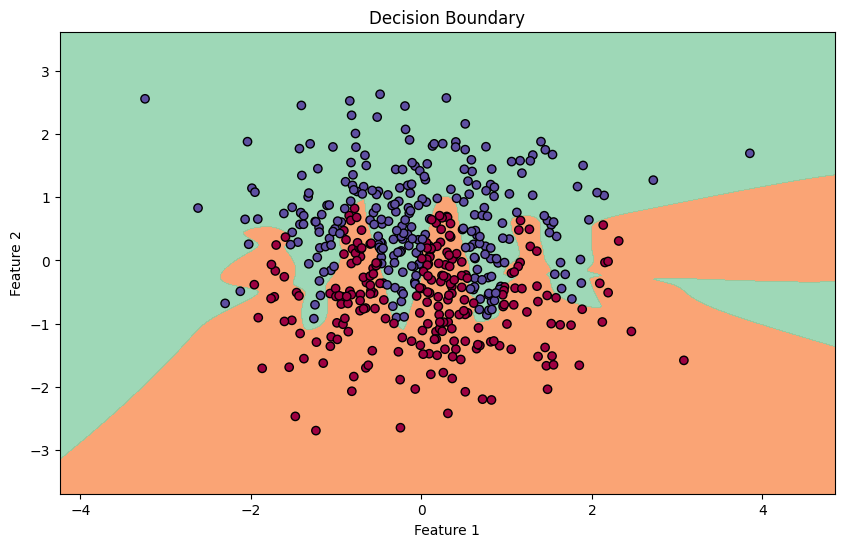

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Generate toy data
np.random.seed(42)
X = np.random.randn(2, 500)  # 2 features, 500 samples
Y = (X[1, :] > np.sin(2 * np.pi * X[0, :])).astype(int).reshape(1, 500)  # 1 if above the sine wave, else 0

# Define layer dimensions
layer_dims = [2, 100, 100, 1]  # Simplified for visualization

# Train the model
parameters = train(X, Y, layer_dims, optimizer="adam", learning_rate=0.1, num_iterations=2000)

# Generate a grid of points for visualization
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict on the grid
grid_points = np.c_[xx.ravel(), yy.ravel()].T
Z, _ = forward_prop(grid_points, parameters)
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.8, cmap=plt.cm.Spectral)
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), edgecolors='k', cmap=plt.cm.Spectral)
plt.title("Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
